# Deep Learning Models for Speech Recognition

<span style="padding-left: 28px;">**<font size=4>Data Science - Capstone Project Submission</font>**</span>

* Student Name: **James Toop**
* Student Pace: **Self Paced**
* Scheduled project review date/time: **29th October 2021 @ 21:30 BST**
* Instructor name: **Jeff Herman / James Irving**
* Blog URL: **https://toopster.github.io/**
---

In [1]:
# Import relevant libraries and modules for creating and training networks
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wave
import soundfile as sf
import librosa, librosa.display
import IPython.display as ipd
import os
import json

import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

import pathlib
from pathlib import Path

import shared_functions.preprocessing as preprocess

In [2]:
# Set seed for reproducibility
seed = 123
tf.random.set_seed(seed)
np.random.seed(seed)

### Create model evaluation functions

In [3]:
def visualise_results(results):
    '''
    Visualise the results from the model history plotting training and
    validation accuracy and loss vs. epoch
        
        Params:
            results: Model history
    '''     
    history = results.history

    plt.figure(figsize=(20,8))
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    plt.subplot(1, 2, 1)
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['Validation Loss', 'Training Loss'], fontsize=12)
    plt.title('Loss', fontsize=18)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    
    plt.subplot(1, 2, 2)
    plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    plt.legend(['Validation Accuracy', 'Training Accuracy'], fontsize=12)
    plt.title('Accuracy', fontsize=18)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.show()

In [4]:
def model_performance(input_model,
                      input_train_X,
                      input_train_y,
                      input_test_X, 
                      input_test_y
                     ): 
    '''
    Visualise the results from the model history plotting training and
    validation accuracy and loss vs. epoch
        
        Params:
            input_model:
            input_train_X (ndarray): Inputs for the training dataset
            input_train_y (ndarray): Targets for the training dataset
            input_test_X (ndarray): Inputs for the test dataset
            input_test_y (ndarray): Targets for the test dataset
    '''    
    # Evaluate training results
    results_train = input_model.evaluate(input_train_X, 
                                         input_train_y, 
                                         verbose=0)
    
    # Evaluate test results
    results_test = input_model.evaluate(input_test_X, 
                                        input_test_y, 
                                        verbose=0)
    
    # Create predictions based on model
    predictions = input_model.predict(input_test_X)
    
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(input_test_y.argmax(axis=1), 
                                   np.round(predictions.argmax(axis=1)))
    
    # Output performance evaluation
    print('CONFUSION MATRIX ------------------')
    print(conf_matrix)

    print('\nTRAIN METRICS ----------------------')
    print('Loss: {}'.format(results_train[0]))
    print('Accuracy: {}%'.format(np.round(results_train[1]*100), 2))

    print('\nTEST METRICS ----------------------')
    print('Loss: {}'.format(results_test[0]))
    print('Accuracy: {}%'.format(np.round(results_test[1]*100), 2))

In [5]:
def check_array_shapes(X_train, y_train, X_val, y_val, X_test, y_test):
    '''
    Output the training, test and validation dataset shapes
        
        Params:
            X_train (ndarray): Inputs for the training dataset
            y_train (ndarray): Targets for the training dataset
            X_val (ndarray): Inputs for the validation dataset
            y_val (ndarray): Targets for the validation dataset
            X_test (ndarray): Inputs for the test dataset
            y_test (ndarray): Targets for the test dataset
    '''       
    print ("Number of training samples: " + str(X_train.shape[0]))
    print ("Number of testing samples: " + str(X_test.shape[0]))
    print ("Number of validation samples: " + str(X_val.shape[0]))
    print ("X_train shape: " + str(X_train.shape))
    print ("y_train shape: " + str(y_train.shape))
    print ("X_test shape: " + str(X_test.shape))
    print ("y_test shape: " + str(y_test.shape))
    print ("X_val shape: " + str(X_val.shape))
    print ("y_val shape: " + str(y_val.shape))

In [6]:
def reformat_y(y):
    '''
    Reformats / One Hot Encodes targets
        
        Params:
            y (ndarray): Input targets
        
        Returns:
            y (ndarray): One hot encoded targets
    '''       
    y = LabelEncoder().fit_transform(y)
    y = tf.keras.utils.to_categorical(y)
    return y

In [7]:
def save_model(save_model, save_path):
    '''
    Save the model
        
        Params:
            save_model : Input Tensorflow model
            save_path (str): Path to save model including file extension .h5
    '''    
    save_model.save(save_path)

### Create training, test and validation datasets

In [8]:
# Create the train, test and validation datasets for the Speech Commands dataset using MFCCs
sc_data_path = "speech_commands_data.json"
(
    sc_X_train,
    sc_y_train,
    sc_X_val,
    sc_y_val,
    sc_X_test,
    sc_y_test,
) = preprocess.create_train_test(sc_data_path, 'MFCCs')

Datasets loaded...


In [9]:
# Create the train, test and validation datasets for the Ultrasuite Top 35 dataset using MFCCs
us_data_path = 'ultrasuite_top35_data.json'
(
    us_X_train, 
    us_y_train, 
    us_X_val, 
    us_y_val, 
    us_X_test, 
    us_y_test,
) = preprocess.create_train_test(us_data_path, 'MFCCs')

Datasets loaded...


In [11]:
# Check the array shapes for the Ultrasuite dataset
check_array_shapes(sc_X_train, 
                   sc_y_train, 
                   sc_X_val, 
                   sc_y_val, 
                   sc_X_test, 
                   sc_y_test)

Number of training samples: 61052
Number of testing samples: 19079
Number of validation samples: 15263
X_train shape: (61052, 44, 13, 1)
y_train shape: (61052,)
X_test shape: (19079, 44, 13, 1)
y_test shape: (19079,)
X_val shape: (15263, 44, 13, 1)
y_val shape: (15263,)


In [10]:
# Check the array shapes for the Ultrasuite dataset
check_array_shapes(us_X_train, 
                   us_y_train, 
                   us_X_val, 
                   us_y_val, 
                   us_X_test, 
                   us_y_test)

Number of training samples: 3942
Number of testing samples: 1233
Number of validation samples: 986
X_train shape: (3942, 44, 13, 1)
y_train shape: (3942,)
X_test shape: (1233, 44, 13, 1)
y_test shape: (1233,)
X_val shape: (986, 44, 13, 1)
y_val shape: (986,)


## Model 1: Create a simple baseline model

In [12]:
def build_baseline_model(input_shape, 
                         output_units, 
                         loss_func='categorical_crossentropy', 
                         learning_rate=0.0001):
    '''
    Build a baseline model
        
        Params:
            input_shape (tuple): Shape of array representing a sample train
            output_units (int): Number of targets / categories
            loss_func (str): Loss function to use
            learning_rate (float): Learning rate
        
        Returns:
            baseline_model: Tensorflow model
    '''     
    baseline_model = tf.keras.models.Sequential()
    baseline_model.add(tf.keras.layers.InputLayer(input_shape=input_shape))
    baseline_model.add(tf.keras.layers.Flatten())
    baseline_model.add(tf.keras.layers.BatchNormalization())
    baseline_model.add(tf.keras.layers.Dense(output_units, activation='softmax'))
    
    # Set optimizer and learning rate
    optimiser = tf.optimizers.Adam(learning_rate=learning_rate)
    
    # Compile the baseline model
    baseline_model.compile(loss=loss_func,
                           optimizer=optimiser,
                           metrics=['acc'])

    # Print summary for model
    baseline_model.summary()
    
    return baseline_model

In [13]:
# Function for fitting the model
def fit_model(model, 
              epochs, 
              batch_size, 
              patience, 
              X_train, 
              y_train, 
              X_val, 
              y_val):
    '''
    Fit the model
        
        Params:
            model : Input Tensorflow model
            epochs (int): Number of training epochs
            batch_size (int): Number of samples per batch
            patience (int): Number of epochs to wait before early stop, 
                            if there no improvement on accuracy
            X_train (ndarray): Inputs for the training dataset
            y_train (ndarray): Targets for the training dataset
            X_val (ndarray): Inputs for the validation dataset
            y_val (ndarray): Targets for the training dataset
        
        Returns:
            results: Training history
    '''    
    # Define early stopping criteria
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', 
                                                      min_delta=0.001, 
                                                      patience=patience)

    # Fit the model
    results = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping])
    return results

### Baseline model for the Speech Commands dataset

In [14]:
# One-hot encode Speech Commands labels
sc_train_y = reformat_y(sc_y_train)
sc_test_y = reformat_y(sc_y_test)
sc_val_y = reformat_y(sc_y_val)

# Create baseline model for Speech Commands dataset
sc_input_shape = (sc_X_train[0].shape)
sc_output_units = 35
sc_baseline_model = build_baseline_model(sc_input_shape, 
                                         sc_output_units, 
                                         learning_rate=0.0001)

# Fit model
sc_epochs = 40
sc_batch_size = 32
sc_patience = 5
sc_baseline_results = fit_model(sc_baseline_model, 
                      sc_epochs, 
                      sc_batch_size, 
                      sc_patience, 
                      sc_X_train, 
                      sc_train_y, 
                      sc_X_val,
                      sc_val_y)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 572)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 572)               2288      
_________________________________________________________________
dense (Dense)                (None, 35)                20055     
Total params: 22,343
Trainable params: 21,199
Non-trainable params: 1,144
_________________________________________________________________
Epoch 1/40
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1884/1908 [============================>.] - ETA: 0s - l

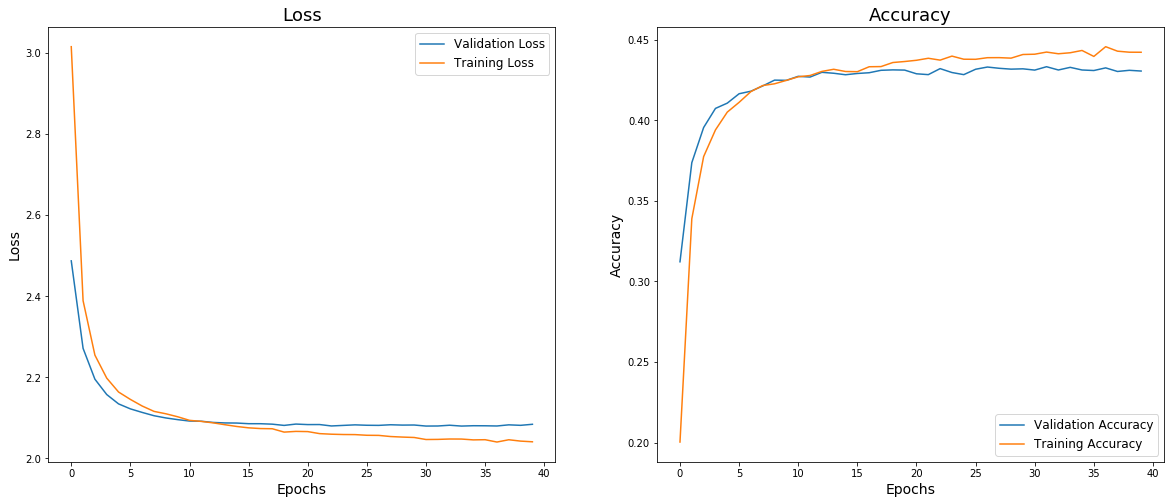

In [15]:
# Visualise the training and validation loss and accuracy across epochs
visualise_results(sc_baseline_results)

In [17]:
# Evaluate the model performance
model_performance(sc_baseline_model, 
                  sc_X_train, 
                  sc_train_y,
                  sc_X_test, 
                  sc_test_y
                 )

CONFUSION MATRIX ------------------
[[233  25   6 ...   4   6  10]
 [ 12 357   1 ...   0   5   2]
 [ 11  10 124 ...   0  24   3]
 ...
 [  6   1   1 ...  94   2  59]
 [  5   0   3 ...   4 365  18]
 [  4   1   3 ...  29  20 313]]

TRAIN METRICS ----------------------
Loss: 1.947283148765564
Accuracy: 47.0%

TEST METRICS ----------------------
Loss: 2.0892109870910645
Accuracy: 43.0%


### Baseline model for the Ultrasuite dataset

In [18]:
# One-hot encode Ultrasuite Top 35 labels
us_train_y = reformat_y(us_y_train)
us_test_y = reformat_y(us_y_test)
us_val_y = reformat_y(us_y_val)

# Create baseline model for Ultrasuite dataset
us_input_shape = (us_X_train[0].shape)
us_output_units = 35
us_baseline_model = build_baseline_model(us_input_shape, 
                                         us_output_units, 
                                         learning_rate=0.0001)

# Fit model
us_epochs = 40
us_batch_size = 32
us_patience = 5
us_baseline_results = fit_model(us_baseline_model, 
                      us_epochs, 
                      us_batch_size, 
                      us_patience, 
                      us_X_train, 
                      us_train_y, 
                      us_X_val, 
                      us_val_y)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 572)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 572)               2288      
_________________________________________________________________
dense_1 (Dense)              (None, 35)                20055     
Total params: 22,343
Trainable params: 21,199
Non-trainable params: 1,144
_________________________________________________________________
Epoch 1/40
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
116/124 [===========================>..] - ETA: 0s - l

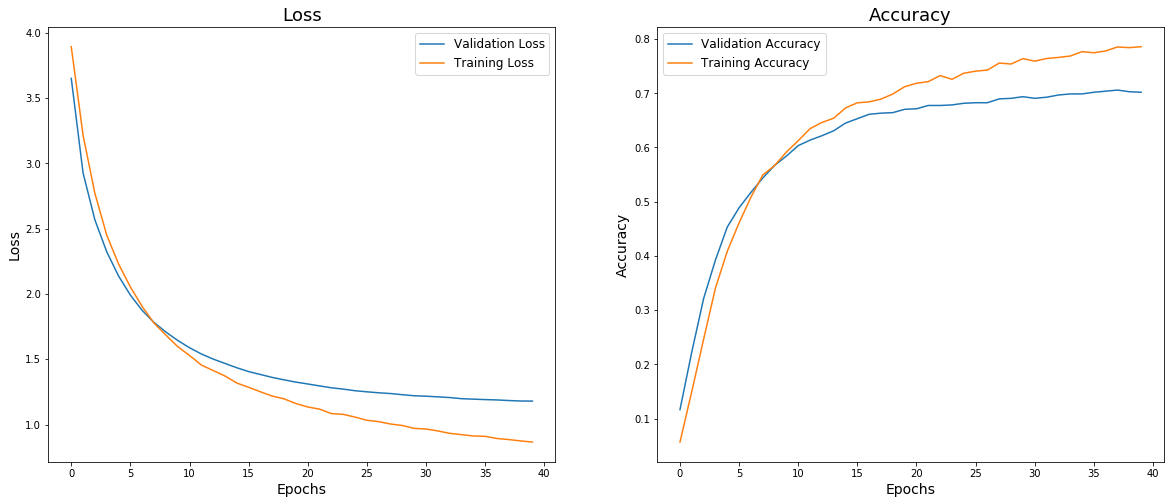

In [19]:
# Visualise the training and validation loss and accuracy across epochs
visualise_results(us_baseline_results)

In [21]:
# Evaluate the model performance
model_performance(us_baseline_model, 
                  us_X_train, 
                  us_train_y,
                  us_X_test, 
                  us_test_y
                 )

CONFUSION MATRIX ------------------
[[15  0  0 ...  0  0  0]
 [ 0 32  0 ...  1  2  0]
 [ 1  1 24 ...  0  0  0]
 ...
 [ 0  1  0 ... 13  1  2]
 [ 0  1  0 ...  0 40  0]
 [ 0  0  0 ...  0  0 12]]

TRAIN METRICS ----------------------
Loss: 0.7894143462181091
Accuracy: 81.0%

TEST METRICS ----------------------
Loss: 1.254226803779602
Accuracy: 70.0%


### Model Conclusion

It's starting point with the training accuracy for the Ultrasuite dataset being 81%. The model is clearly overfitting the training data and is not generalising well when shown unseen data given the validation accuracy of 70%.

What is of particular note is the vastly different accuracies when compared to the Speech Commands dataset which are both under 50%.  

This could suggest that a more simple model works better for audio samples from children with a speech sound disorder.

## Model 2: Baseline model with increased learning rate and batch size

In [22]:
# Create second baseline model on Ultrasuite dataset changing the learning rate and batch size
us_input_shape = (us_X_train[0].shape)
us_output_units = 35
us_baseline_model_2 = build_baseline_model(us_input_shape, 
                                           us_output_units, 
                                           learning_rate=0.001)

 
# Fit model
us_epochs = 40
us_batch_size = 64
us_patience = 5
us_baseline_results_2 = fit_model(us_baseline_model_2, 
                      us_epochs, 
                      us_batch_size, 
                      us_patience, 
                      us_X_train, 
                      us_train_y, 
                      us_X_val, 
                      us_val_y)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 572)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 572)               2288      
_________________________________________________________________
dense_2 (Dense)              (None, 35)                20055     
Total params: 22,343
Trainable params: 21,199
Non-trainable params: 1,144
_________________________________________________________________
Epoch 1/40
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
62/62 [==============================] - ETA: 0s - los

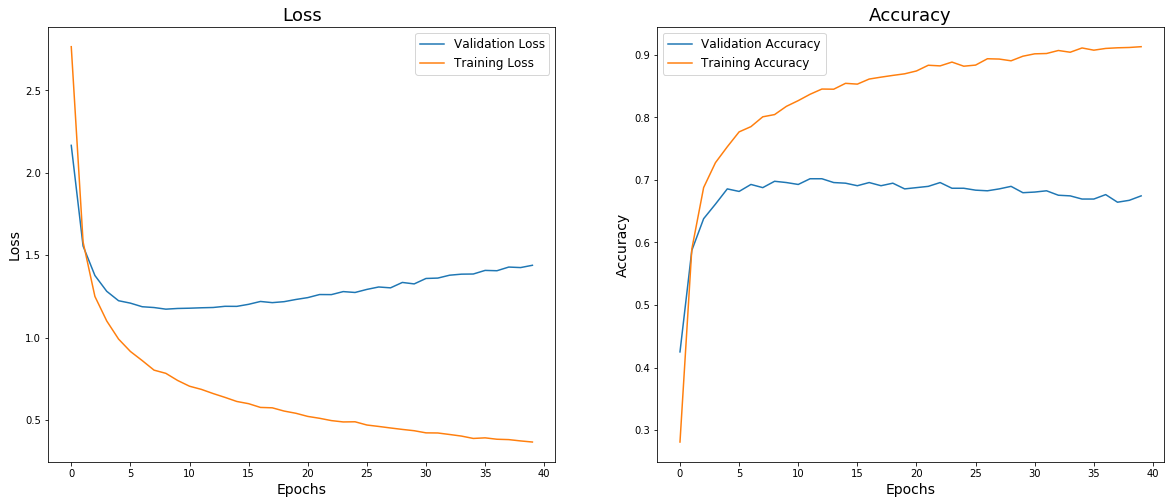

In [23]:
# Visualise the training and validation loss and accuracy across epochs
visualise_results(us_baseline_results_2)

In [25]:
# Evaluate the model performance
model_performance(us_baseline_model_2, 
                  us_X_train, 
                  us_train_y,
                  us_X_test, 
                  us_test_y
                 )

CONFUSION MATRIX ------------------
[[14  0  0 ...  0  0  1]
 [ 0 28  0 ...  3  1  0]
 [ 1  0 28 ...  0  0  0]
 ...
 [ 1  1  0 ... 13  0  1]
 [ 1  0  0 ...  0 43  0]
 [ 0  0  0 ...  0  0 18]]

TRAIN METRICS ----------------------
Loss: 0.28699809312820435
Accuracy: 94.0%

TEST METRICS ----------------------
Loss: 1.5567854642868042
Accuracy: 65.0%


### Model Conclusion

We have improved the training accuracy of the baseline model, to 94%, by increasing the learning rate and increasing the batch size but this has only served to exascerbate the issue of overfitting with test accuracy not reducing to 65% and the difference between the two plots being dramatic.

In an effort to deal with the issue of overfitting, we will introduce some regularization layers and see what effect they have on performance.

## Model 3: Adding hidden layers to the baseline model, deepening the network

In [26]:
# Build a second baseline model
def build_model_2(input_shape, 
                  output_units, 
                  loss_func='categorical_crossentropy', 
                  learning_rate=0.0001):
    
    model_2 = tf.keras.models.Sequential()
    model_2.add(tf.keras.layers.InputLayer(input_shape=input_shape))
    model_2.add(tf.keras.layers.Flatten())
    model_2.add(tf.keras.layers.BatchNormalization())
    model_2.add(tf.keras.layers.Dense(256, activation='relu'))
#     model_2.add(tf.keras.layers.Dropout(0.3))
    model_2.add(tf.keras.layers.Dense(128, activation='relu'))
    model_2.add(tf.keras.layers.Dense(64, activation='relu'))
    model_2.add(tf.keras.layers.Dense(output_units, activation='softmax'))
    
    # Set optimizer and learning rate
    optimiser = tf.optimizers.Adam(learning_rate=learning_rate)
    
    # Compile the baseline model
    model_2.compile(loss=loss_func,
                           optimizer=optimiser,
                           metrics=['acc'])

    # Print summary for model
    model_2.summary()
    
    return model_2

In [27]:
# Create baseline model for Ultrasuite dataset
us_input_shape = (us_X_train[0].shape)
us_output_units = 35
us_model_2 = build_model_2(us_input_shape, 
                           us_output_units, 
                           learning_rate=0.0001)

# Fit model
us_epochs = 40
us_batch_size = 64
us_patience = 3
us_results_3 = fit_model(us_model_2, 
                      us_epochs, 
                      us_batch_size, 
                      us_patience, 
                      us_X_train, 
                      us_train_y, 
                      us_X_val, 
                      us_val_y)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 572)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 572)               2288      
_________________________________________________________________
dense_3 (Dense)              (None, 256)               146688    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 35)                2275      
Total params: 192,403
Trainable params: 191,259
Non-trainable params: 1,144
____________________________________________

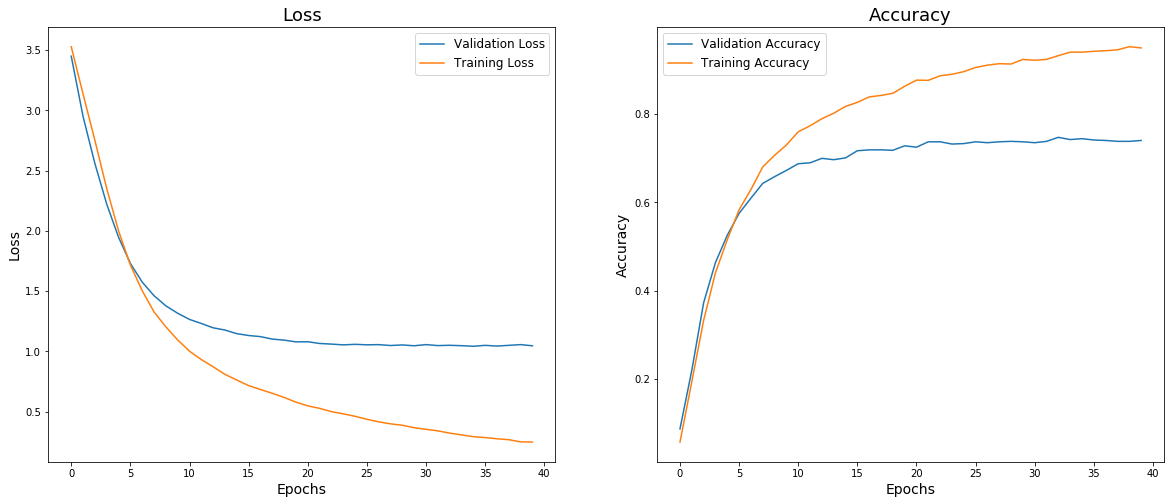

In [28]:
# Visualise the training and validation loss and accuracy across epochs
visualise_results(us_results_3)

In [30]:
# Evaluate the model performance
model_performance(us_model_2, 
                  us_X_train, 
                  us_train_y,
                  us_X_test, 
                  us_test_y
                 )

CONFUSION MATRIX ------------------
[[19  0  0 ...  1  1  0]
 [ 0 34  0 ...  0  2  0]
 [ 0  0 26 ...  0  0  0]
 ...
 [ 1  0  0 ... 16  0  1]
 [ 0  1  0 ...  0 43  0]
 [ 0  0  0 ...  1  0 18]]

TRAIN METRICS ----------------------
Loss: 0.19082011282444
Accuracy: 96.0%

TEST METRICS ----------------------
Loss: 1.085261344909668
Accuracy: 72.0%


### Running the model using Mel Spectrograms instead of MFCCs

A thought exercise more than anything else, just to see if there are any performance gains that can be made by using Mel Spectrograms instead of MFCCs.

In [31]:
# Create the train, test and val datasets for the Ultrasuite top 35 subset using Mel Spectrograms
us_data_path = 'ultrasuite_top35_data_melspec.json'
(
    X_train_mel, 
    y_train_mel, 
    X_val_mel, 
    y_val_mel, 
    X_test_mel, 
    y_test_mel,
) = preprocess.create_train_test(us_data_path, 'mel_specs')

Datasets loaded...


In [32]:
# Create model using Mel Spectrograms instead of MFCCs
us_mel_input_shape = (X_train_mel.shape[1], X_train_mel.shape[2], 1)
us_mel_output_units = 35
us_mel_model = build_model_2(us_mel_input_shape, 
                             us_mel_output_units, 
                             learning_rate=0.0001)

# One-hot encode Speech Commands labels
mel_train_y = reformat_y(y_train_mel)
mel_test_y = reformat_y(y_test_mel)
mel_val_y = reformat_y(y_val_mel)

# Fit model
us_mel_epochs = 40
us_mel_batch_size = 64
us_mel_patience = 3
us_mel_results = fit_model(us_mel_model, 
                           us_mel_epochs, 
                           us_mel_batch_size, 
                           us_mel_patience, 
                           X_train_mel, 
                           mel_train_y, 
                           X_val_mel, 
                           mel_val_y)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 5632)              0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 5632)              22528     
_________________________________________________________________
dense_7 (Dense)              (None, 256)               1442048   
_________________________________________________________________
dense_8 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_10 (Dense)             (None, 35)                2275      
Total params: 1,508,003
Trainable params: 1,496,739
Non-trainable params: 11,264
_______________________________________

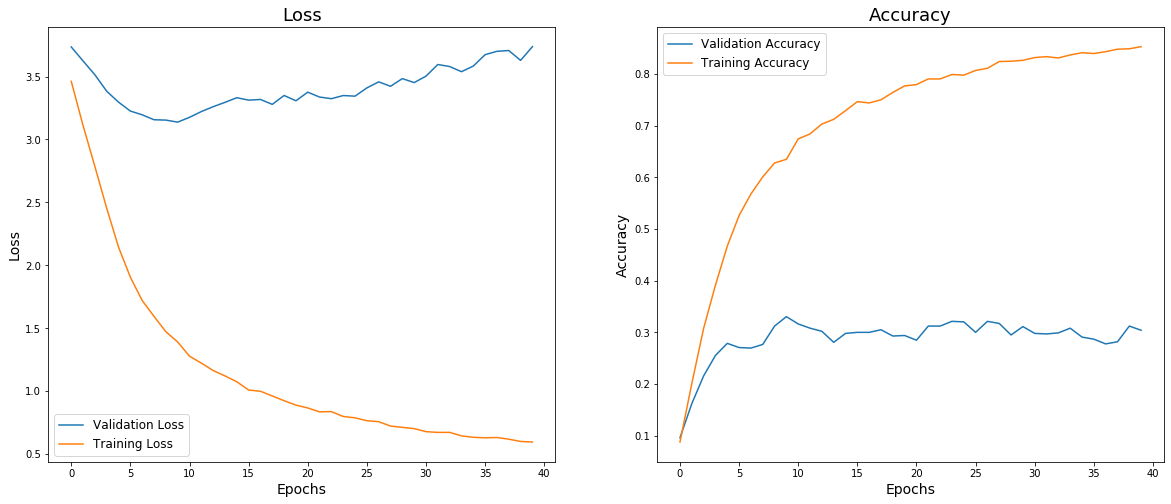

In [33]:
# Visualise the training and validation loss and accuracy across epochs
visualise_results(us_mel_results)

In [35]:
# Evaluate the model performance
model_performance(us_mel_model, 
                  X_train_mel, 
                  mel_train_y,
                  X_test_mel, 
                  mel_test_y
                 )

CONFUSION MATRIX ------------------
[[ 6  0  0 ...  3  2  0]
 [ 1 18  0 ...  0  6  0]
 [ 0  1  3 ...  1  9  0]
 ...
 [ 0  0  0 ...  5  7  0]
 [ 0  3  0 ...  0 40  0]
 [ 3  1  0 ...  0  3  4]]

TRAIN METRICS ----------------------
Loss: 1.8458300828933716
Accuracy: 53.0%

TEST METRICS ----------------------
Loss: 3.5853798389434814
Accuracy: 30.0%


## Model 4: Convolutional Neural Network

In [36]:
# Build a CNN model

def build_cnn_model(input_shape, 
                    output_units, 
                    loss='categorical_crossentropy', 
                    learning_rate=0.0001):

    cnn_model = tf.keras.models.Sequential()

    # 1st convolutional layer
    cnn_model.add(tf.keras.layers.Conv2D(32, (3, 3), 
                                         activation='relu', 
                                         input_shape=input_shape,
                                         kernel_regularizer=tf.keras.regularizers.l2(0.005)))
    cnn_model.add(tf.keras.layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.MaxPooling2D((2, 2), 
                                               strides=(2,2), 
                                               padding='same'))

    # 2nd convolutional layer
    cnn_model.add(tf.keras.layers.Conv2D(32, (4, 4), 
                                     activation='relu',
                                     kernel_regularizer=tf.keras.regularizers.l2(0.005)))
    cnn_model.add(tf.keras.layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.MaxPooling2D((3, 3), 
                                               strides=(2,2), 
                                               padding='same'))

    # 3rd convolutional layer
    cnn_model.add(tf.keras.layers.Conv2D(64, (2, 2), 
                                         activation='relu',
                                         kernel_regularizer=tf.keras.regularizers.l2(0.005)))
    cnn_model.add(tf.keras.layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.MaxPooling2D((2, 2), 
                                               strides=(2,2), 
                                               padding='same'))

    # Flatten output and feed into dense layer
    cnn_model.add(tf.keras.layers.Flatten())
    cnn_model.add(tf.keras.layers.Dense(32, activation='relu'))
    cnn_model.add(tf.keras.layers.Dropout(0.3))

    # Softmax output layer
    cnn_model.add(tf.keras.layers.Dense(output_units, activation='softmax'))

    optimiser = tf.optimizers.Adam(learning_rate=learning_rate)

    # Compile model
    cnn_model.compile(optimizer=optimiser,
                  loss=loss,
                  metrics=['acc'])

    # Print summary for model
    cnn_model.summary()

    return cnn_model

### CNN model for the Speech Commands dataset

In [37]:
# Create CNN model using Speech Commands MFCCs
sc_cnn_input_shape = (sc_X_train.shape[1], sc_X_train.shape[2], 1)
sc_output_units = 35
sc_cnn_model = build_cnn_model(sc_cnn_input_shape, 
                               sc_output_units, 
                               learning_rate=0.0001)

 
# Fit model to Speech Commands data
sc_epochs = 40
sc_batch_size = 64
sc_patience = 3
sc_cnn_results = fit_model(sc_cnn_model, 
                      sc_epochs, 
                      sc_batch_size, 
                      sc_patience, 
                      sc_X_train, 
                      sc_train_y, 
                      sc_X_val, 
                      sc_val_y)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 42, 11, 32)        320       
_________________________________________________________________
batch_normalization_5 (Batch (None, 42, 11, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 21, 6, 32)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 3, 32)         16416     
_________________________________________________________________
batch_normalization_6 (Batch (None, 18, 3, 32)         128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 2, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 1, 64)         

954/954 [==============================] - 44s 46ms/step - loss: 0.5080 - acc: 0.8732 - val_loss: 0.4398 - val_acc: 0.8973
Epoch 40/40
954/954 [==============================] - 67s 70ms/step - loss: 0.5010 - acc: 0.8752 - val_loss: 0.4468 - val_acc: 0.8958


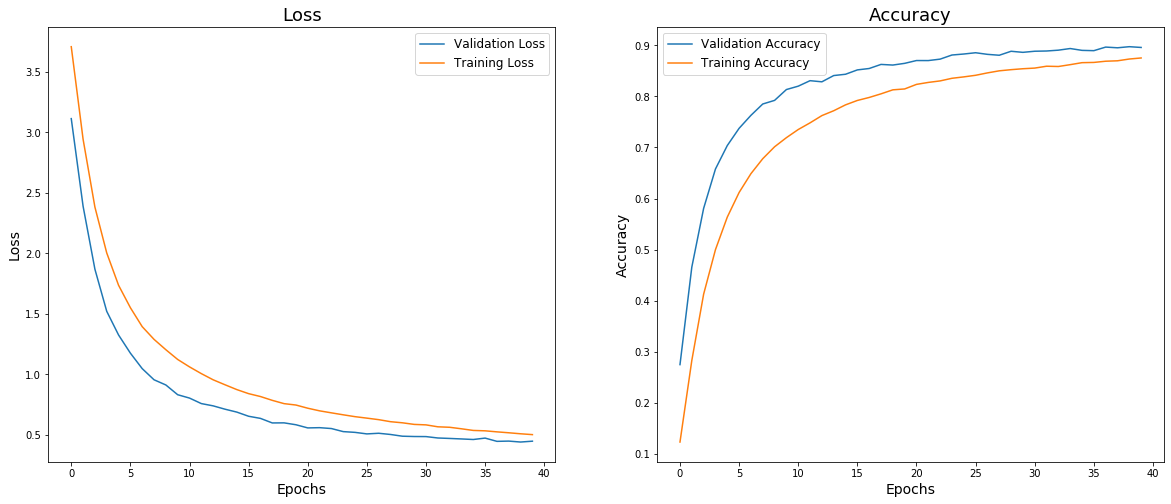

In [38]:
# Visualise the training and validation loss and accuracy across epochs
visualise_results(sc_cnn_results)

In [40]:
# Evaluate the model performance
model_performance(sc_cnn_model, 
                  sc_X_train, 
                  sc_train_y,
                  sc_X_test, 
                  sc_test_y
                 )

CONFUSION MATRIX ------------------
[[613   3   0 ...   0   1   2]
 [  5 629   0 ...   0   2   1]
 [  0   1 339 ...   0   4   0]
 ...
 [  0   0   0 ... 225   0  46]
 [  1   0   1 ...   1 604   2]
 [  0   0   3 ...  34   4 602]]

TRAIN METRICS ----------------------
Loss: 0.32391873002052307
Accuracy: 93.0%

TEST METRICS ----------------------
Loss: 0.4416976571083069
Accuracy: 90.0%


### CNN model for the Ultrasuite dataset

In [41]:
# Create CNN model using Ultrasuite MFCCs
us_cnn_input_shape = (us_X_train.shape[1], us_X_train.shape[2], 1)
us_output_units = 35
us_cnn_model = build_cnn_model(us_cnn_input_shape, 
                               us_output_units, 
                               learning_rate=0.0001)

 
# Fit model to Ultrasuite data
us_epochs = 50
us_batch_size = 16
us_patience = 3
us_cnn_results = fit_model(us_cnn_model, 
                      us_epochs, 
                      us_batch_size, 
                      us_patience, 
                      us_X_train, 
                      us_train_y, 
                      us_X_val, 
                      us_val_y)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 42, 11, 32)        320       
_________________________________________________________________
batch_normalization_8 (Batch (None, 42, 11, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 21, 6, 32)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 18, 3, 32)         16416     
_________________________________________________________________
batch_normalization_9 (Batch (None, 18, 3, 32)         128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 9, 2, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 1, 64)         

247/247 [==============================] - 6s 23ms/step - loss: 1.3139 - acc: 0.6936 - val_loss: 1.3899 - val_acc: 0.7110
Epoch 40/50
247/247 [==============================] - 5s 21ms/step - loss: 1.2923 - acc: 0.7055 - val_loss: 1.3968 - val_acc: 0.7160
Epoch 41/50
247/247 [==============================] - 5s 21ms/step - loss: 1.2689 - acc: 0.7057 - val_loss: 1.3584 - val_acc: 0.7302
Epoch 42/50
247/247 [==============================] - 4s 16ms/step - loss: 1.2618 - acc: 0.7103 - val_loss: 1.3751 - val_acc: 0.7201
Epoch 43/50
247/247 [==============================] - 4s 15ms/step - loss: 1.2337 - acc: 0.7139 - val_loss: 1.3636 - val_acc: 0.7221
Epoch 44/50
247/247 [==============================] - 4s 15ms/step - loss: 1.2307 - acc: 0.7166 - val_loss: 1.3521 - val_acc: 0.7241
Epoch 45/50
247/247 [==============================] - 4s 15ms/step - loss: 1.2308 - acc: 0.7050 - val_loss: 1.3500 - val_acc: 0.7262
Epoch 46/50
247/247 [==============================] - 4s 15ms/step - loss

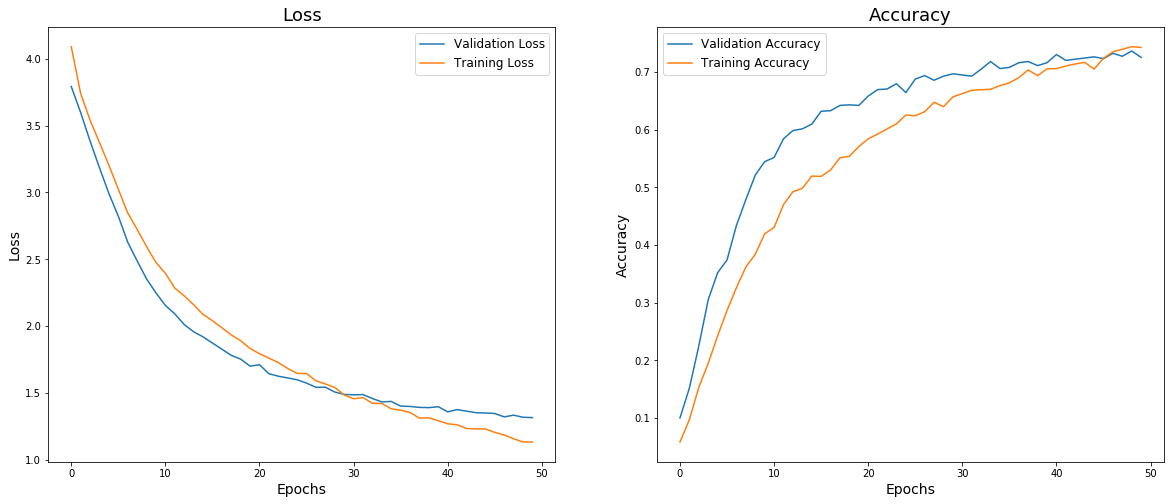

In [42]:
# Visualise the training and validation loss and accuracy across epochs
visualise_results(us_cnn_results)

In [46]:
save_model(us_cnn_model, 'final_model.h5')

## Final Model Performance Evaluation

In [44]:
model_performance(us_cnn_model, 
                  us_X_train, 
                  us_train_y,
                  us_X_test, 
                  us_test_y
                 )

CONFUSION MATRIX ------------------
[[17  0  0 ...  0  0  1]
 [ 0 35  0 ...  1  0  1]
 [ 0  0 29 ...  0  1  0]
 ...
 [ 1  0  0 ... 15  1  0]
 [ 0  1  2 ...  0 43  0]
 [ 1  0  0 ...  0  0 16]]

TRAIN METRICS ----------------------
Loss: 0.7186428308486938
Accuracy: 89.0%

TEST METRICS ----------------------
Loss: 1.3699027299880981
Accuracy: 72.0%


In [48]:
# Import necessary libraries for classification report
from sklearn.metrics import classification_report

preds = us_cnn_model.predict(us_X_test)

us_keywords = [
    'crab',
    'fishing',
    'gown',
    'say',
    'boy',
    'bridge',
    'in',
    'zebra',
    'times',
    'sheep',
    'tiger',
    'teeth',
    'pack',
    'helicopter',
    'got',
    'ear',
    'cab',
    'thank',
    'tie',
    'gloves',
    'umbrella',
    'spider',
    'was',
    'watch',
    'monkey',
    'scissors',
    'yellow',
    'frog',
    'or',
    'on',
    'ken',
    'school',
    'five',
    'elephant',
    'four']

# Print the classification report
print(classification_report(us_test_y.argmax(axis=1), 
                            preds.argmax(axis=1), 
                            target_names=us_keywords))

              precision    recall  f1-score   support

        crab       0.74      0.61      0.67        28
     fishing       0.80      0.81      0.80        43
        gown       0.78      0.76      0.77        38
         say       0.74      0.73      0.73        62
         boy       0.96      0.81      0.88        27
      bridge       0.89      0.82      0.85        49
          in       0.59      0.53      0.56        45
       zebra       0.62      0.69      0.66        29
       times       0.60      0.58      0.59        31
       sheep       0.76      0.61      0.68        31
       tiger       0.65      0.56      0.60        27
       teeth       0.56      0.68      0.61        22
        pack       0.88      0.68      0.77        22
  helicopter       0.85      0.94      0.89        47
         got       0.67      0.57      0.62        49
         ear       0.81      0.74      0.77        34
         cab       0.69      0.75      0.72        24
       thank       0.74    

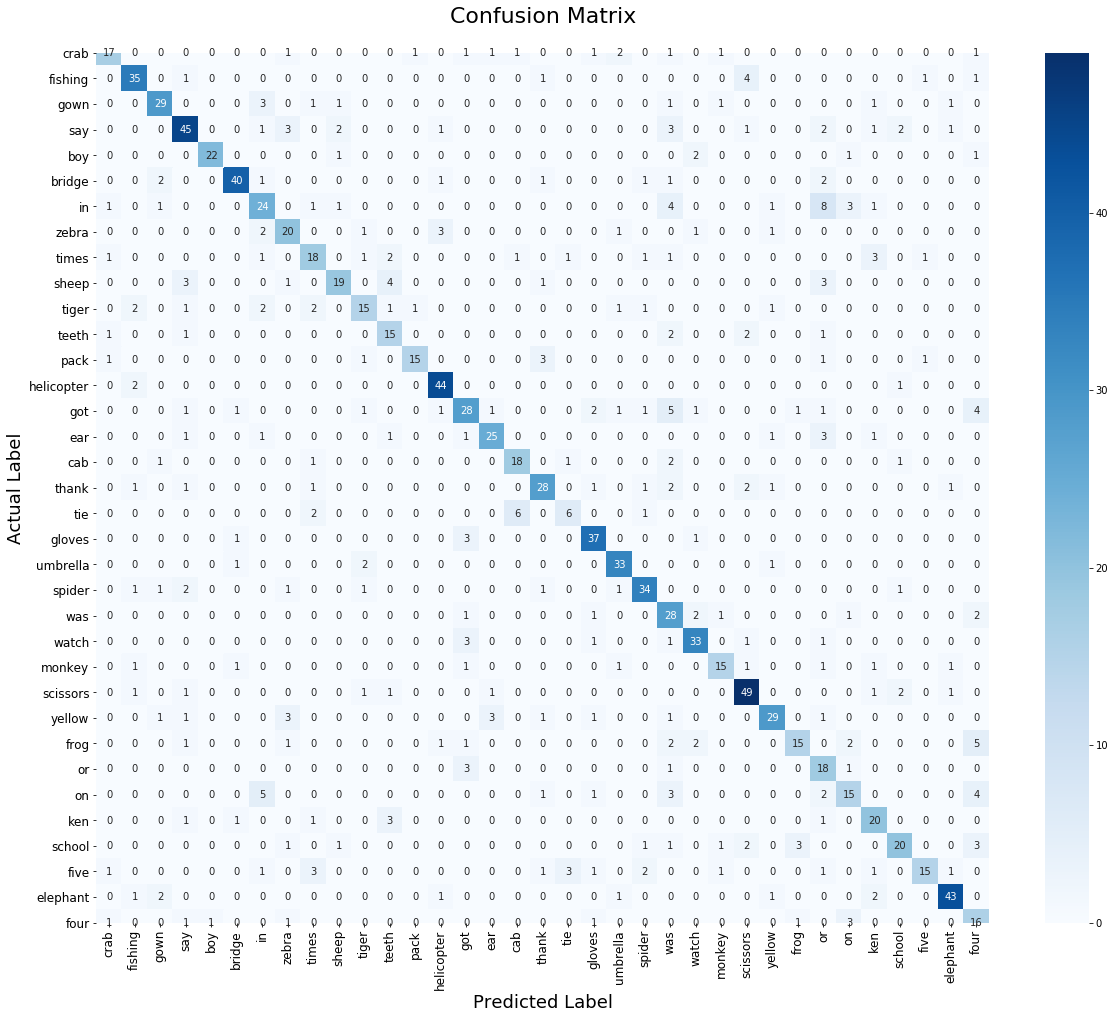

In [59]:
# Use Seaborn to make the confusion matrix more visually presentable
cm = confusion_matrix(us_test_y.argmax(axis=1), 
                      np.round(preds.argmax(axis=1)))

plt.figure(figsize=(20,16))
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, fmt='g', cmap='Blues')

ax.set_title('Confusion Matrix', fontsize=22, pad=30)
ax.set_xlabel('Predicted Label', fontsize=18)
ax.set_ylabel('Actual Label', fontsize=18)
ax.xaxis.set_ticklabels(us_keywords, rotation=90, fontsize=12)
ax.yaxis.set_ticklabels(us_keywords, rotation=0, fontsize=12)
plt.show();

### Making a prediction on an unseen audio sample

In [56]:
# Load the audio sample and preview
target_sample = 'audio/martha-umbrella.wav'
target_label = 'Umbrella'
audio_sample, sr = librosa.load(target_sample)
print('Audio sample:', target_label)
ipd.Audio(audio_sample, rate=sr)

Audio sample: Umbrella


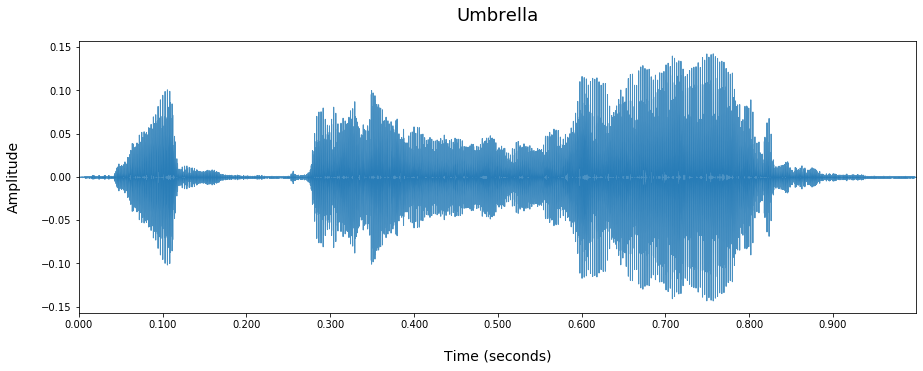

In [57]:
# Plot the waveform for the specific audio sample
plt.figure(figsize=(15, 5))
plt.title(target_label, fontsize=18, pad=20)
librosa.display.waveplot(audio_sample, sr, alpha=0.8)
plt.xlabel('Time (seconds)', fontsize=14, labelpad=20)
plt.ylabel('Amplitude', fontsize=14, labelpad=20)
plt.show();

In [58]:
# Run inference on the unseen audio file
mfccs = librosa.feature.mfcc(audio_sample, 
                             sr,
                             n_mfcc=13, 
                             n_fft=2048, 
                             hop_length=512)
mfccs = mfccs.T
mfccs = mfccs[np.newaxis, ..., np.newaxis]

prediction = us_cnn_model.predict(mfccs)
predicted_index = np.argmax(prediction)

predicted_keyword = us_keywords[predicted_index]
print('Martha says...',predicted_keyword, '!')

Martha says... umbrella !


## Overall Conclusion

Initial models did not generalise well and tended to overfit the training data. Subsequent changes to parameters significantly improved the training accuracy but, again were overfitting the training data.

Whilst it does not have a high accuracy score, this final model using a Convolutional Neural Network produced the best results classifying over 70% of the “unseen” audio samples whilst minimising the overfitting to training data.  Looking at the classification report, it is also clear that the model performs better for more identifiable words such as `scissors` or `umbrella`.

The very nature of speech sound disorders mean that a model that has been simply trained on audio samples of "typical" speech will generally be more accurate than one that has been trained on audio samples of "atypical" speech as demonstrated above with the model comparison between the Speech Commands and Ultrasuite datasets.

### Recommendations

<img src="images/google-recorder-app.png" title="Google Recorder App Screenshot" width="25%" style="float: right; padding-left: 30px;"/>

It is envisaged that the model would be used in the form of a mobile app, similar to that of Google Recorder (see image), that could be activated by the parent in order to capture the child speaking.

The app would also enable the parent to crop or isolate the audio sample and would provide a side-by-side prediction or transcript of what the child was saying.

This could even be provided as a setting within the Google recorder app itself that allowed the user, in this case the parent, to switch between the standard speech recognition model and our final model specifically trained for children with speech disorders.

Given this eventual usage of this model, it is arguable the app would be more useful if it suggested three potential words in order of likelihood, giving the parent options of what the child might be trying to communicate.

The accuracy of the final model is suitable enough to go ahead with a soft launch of the app to a controlled group of parents, in part for testing but also as a way of collecting additional data to improve the model.

### Future Work

Future work to improve the model could include:

* Utilise other model architectures and enable them to accept longer audio samples as these are more representative of atypical speech patterns.

* Source additional data in the form of further audio samples potentially even using the app as a means for gathering additional samples and improving the model.

* Use data augmentation when training the model, in particular the [MixSpeech](https://arxiv.org/abs/2102.12664) method that could take a weighted combination of mel-spectrograms and MFCCs in order to improve model performance.

<hr size="1" />
<small>
<strong>Sources / Code adapted from:</strong><br/>
    * <a href="https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/" target="_new">Hands-On Machine Learning with Scikit-Learn, Keras & Tensorflow - Aurélien Géron</a><br/>
    * <a href="https://github.com/musikalkemist/Deep-Learning-Audio-Application-From-Design-to-Deployment" target="_new">Deep Learning Audio Application from Design to Deployment - Valerio Velardo - The Sound of AI</a><br/>
</small>